# **Mô hình ARIMA**

## **Thư viện**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

## **Dữ liệu**

In [4]:
file_path = "..//data//processed//EUR_VND_Exchange_Rate_2020_2025_clean.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

## **Kiểm định tính dừng**

In [4]:
from statsmodels.tsa.stattools import adfuller

# ADF test gốc
result = adfuller(df['Sell'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("=> Chuỗi {} dừng".format("có" if result[1] < 0.05 else "không"))


ADF Statistic: -1.2253450973203501
p-value: 0.6625989844374178
=> Chuỗi không dừng


In [5]:
# Lấy sai phân bậc 1
df['Sell_diff'] = df['Sell'].diff().dropna()
result_diff = adfuller(df['Sell_diff'].dropna())
print("\nSau sai phân 1:")
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])
print("=> Chuỗi {} dừng".format("có" if result_diff[1] < 0.05 else "không"))


Sau sai phân 1:
ADF Statistic: -42.30414205661225
p-value: 0.0
=> Chuỗi có dừng


=> d = 1

## **Kiểm tra tính mùa vụ, xu hướng**

## **PACF và ACF xác định bậc p và q**

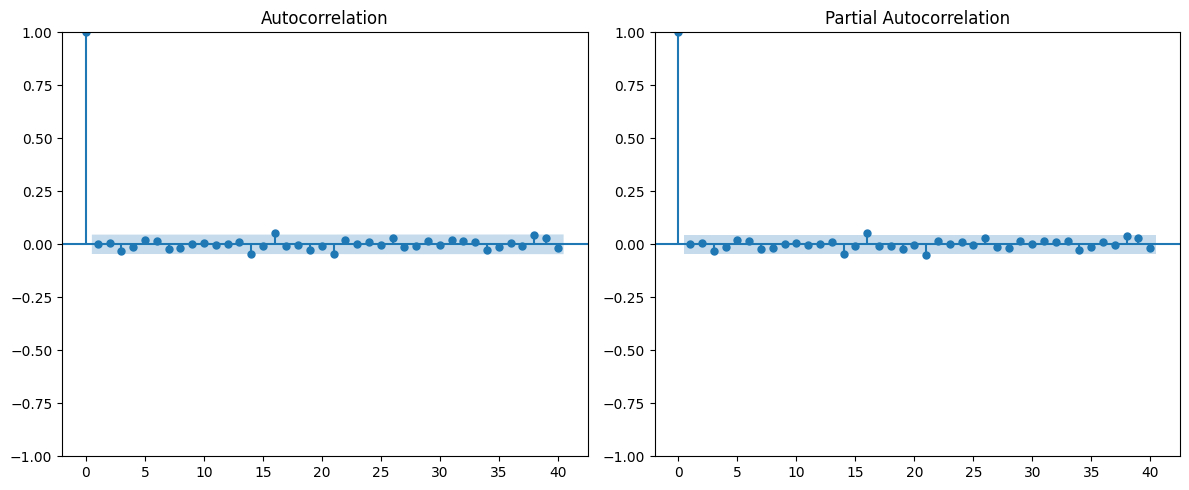

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(df['Sell'].diff().dropna(), ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(df['Sell'].diff().dropna(), ax=plt.gca(), lags=40, method='ywm')
plt.tight_layout()
plt.show()


ACF: Không có điểm lag nào (ngoại trừ lag 0) vượt vùng tin cậy => không có thành phần MA rõ ràng => q có thể bằng 0.

PACF: Tất cả giá trị nằm trong vùng tin cậy => không có thành phần AR rõ ràng => p có thể bằng 0.


## **Mô hình ARIMA**

### **Tìm mô hình tốt nhất**

In [5]:
#Dữ liệu
y = df['Sell']

train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]


In [8]:
import warnings
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None
best_model = None

max_p = 10
max_q = 10

for p in range(max_p + 1):
    for q in range(max_q + 1):
        if p == 0 and q == 0:
            continue
        try:
            model = ARIMA(train, order=(p, 1, q))
            model_fit = model.fit()

            pvalues = model_fit.pvalues
            if all(pval < 0.05 for pval in pvalues):
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, 1, q)
                    best_model = model_fit
        except:
            continue

if best_model:
    print(f"Mô hình ARIMA tốt nhất: ARIMA{best_order}")
    print(f"AIC: {best_aic:.4f}")
    print("\nTóm tắt mô hình:")
    print(best_model.summary())
else:
    print("Không tìm được mô hình thỏa mãn.")


Mô hình ARIMA tốt nhất: ARIMA(2, 1, 2)
AIC: 17874.6194

Tóm tắt mô hình:
                               SARIMAX Results                                
Dep. Variable:                   Sell   No. Observations:                 1469
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8932.310
Date:                Mon, 26 May 2025   AIC                          17874.619
Time:                        23:33:46   BIC                          17901.078
Sample:                    04-01-2020   HQIC                         17884.487
                         - 04-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3863      0.036     10.678      0.000       0.315       0.457
ar.L2         -0.9744      0.033    -29.880      0.000    

### **Huấn luyện trên mô hình tốt nhất**

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Huấn luyện mô hình ARIMA(2,1,2)
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Dự đoán trên tập test
forecast_result = model_fit.get_forecast(steps=len(test))
y_pred = forecast_result.predicted_mean
y_pred.index = test.index 

### **Đánh giá mô hình**

In [8]:
mae = mean_absolute_error(test, y_pred)
mse = mean_squared_error(test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - y_pred) / test)) * 100

print("Đánh giá mô hình ARIMA(2,1,2):")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")


Đánh giá mô hình ARIMA(2,1,2):
MAE : 482.7980
MSE : 311299.8513
RMSE: 557.9425
MAPE: 1.7294%


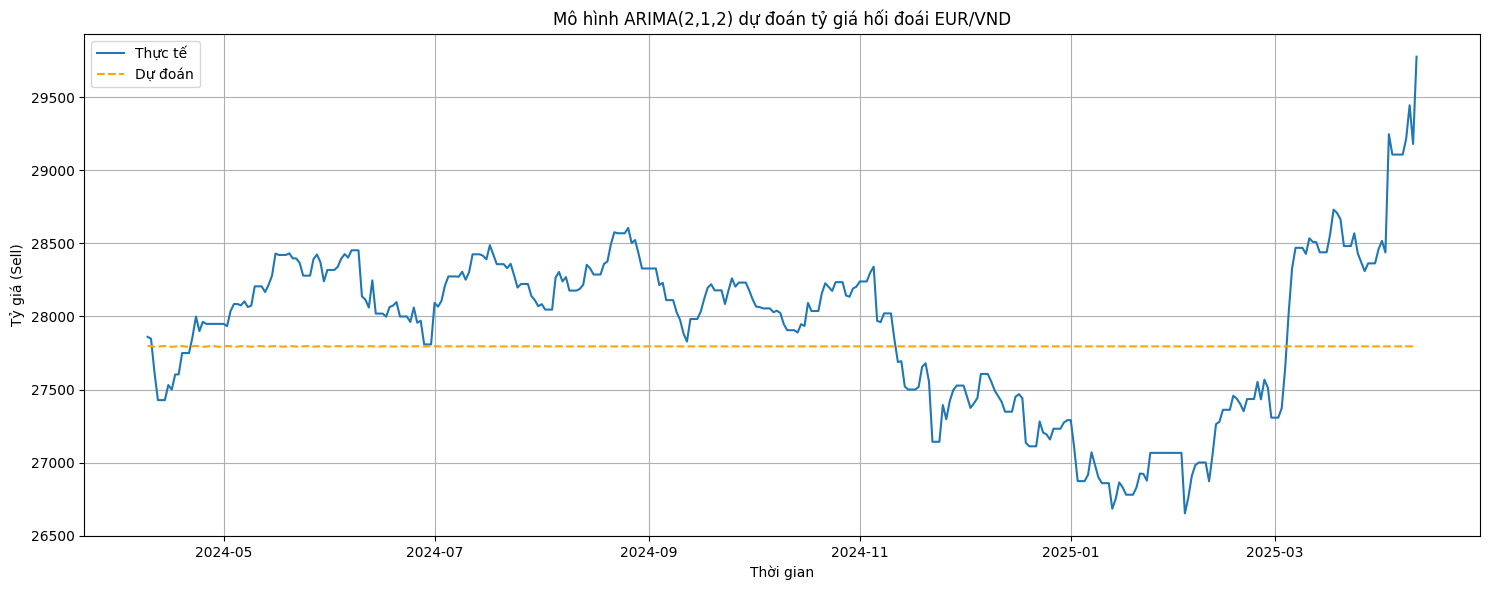

In [9]:
# Vẽ biểu đồ so sánh dự đoán và thực tế
plt.figure(figsize=(15, 6))
plt.plot(test, label='Thực tế')
plt.plot(y_pred, label='Dự đoán', linestyle="dashed", color='orange')
plt.title('Mô hình ARIMA(2,1,2) dự đoán tỷ giá hối đoái EUR/VND')
plt.xlabel('Thời gian')
plt.ylabel('Tỷ giá (Sell)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Dự đoán 7 ngày tiếp theo**

In [10]:
full_data = pd.concat([train, test])
model_full = ARIMA(full_data, order=(2, 1, 2))
model_fit_full = model_full.fit()

# Dự báo 7 ngày tiếp theo
forecast_7days = model_fit_full.get_forecast(steps=7)
forecast_mean_7days = forecast_7days.predicted_mean

last_date = full_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
forecast_mean_7days.index = forecast_index

print("Dự báo 7 ngày tiếp theo:")
print(forecast_mean_7days)


Dự báo 7 ngày tiếp theo:
2025-04-12    29779.564777
2025-04-13    29777.236883
2025-04-14    29774.505914
2025-04-15    29777.837124
2025-04-16    29779.069896
2025-04-17    29775.398099
2025-04-18    29775.729161
Freq: D, Name: predicted_mean, dtype: float64
